# LES ACCIDENTS DE LA CIRCULATION - JUDILIBRE

Pour ce projet de NLP, nous avons décidé de travailler sur les accidents de la route.

Les accidents de la route sont l'une des principales causes de mortalité dans le monde. Selon l'Organisation Mondiale de la Santé (OMS), environ 1,35 million de personnes meurent chaque année sur les routes, soit plus de 3 500 décès par jour. Les accidents de la route ont des conséquences dramatiques pour les victimes et leurs familles, mais aussi pour la société dans son ensemble, car ils représentent un coût économique et social important.

Le NLP permet d'extraire des informations pertinentes à partir de textes non structurés tels que les de décisions de justice et de les transformer en données structurées pour une analyse plus approfondie. Dans ce contexte, ce projet de NLP vise à analyser les décisions de justice relatives aux accidents de la route à partir de textes récupérés sur Judilibre.

## Importation des libraries

In [30]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import ImageColorGenerator
from PIL import Image
import plotly.express as px
from nltk.text import Text
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer
#import prince
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import gensim
from gensim import corpora
from gensim.models import LdaModel

## Importation des données 

On importe les données que récupérées sur le site judilibre. Nos données sont des textes décrivant les décisions de justices prisent concernant des accidents de la route. On importe deux jeux de données, le premier contient les données nettoyées et tokenisées. Chaque document est donc une liste de mots. Le deuxième jeu de données contient des phrases entières. On importe nos données sous ces deux formes car elles seront toutes deux importantes pour différents aspects de notre analyse.

In [19]:
df = pd.read_csv("cleaned_text2.csv")

mots = []

for element in df['text']:
    if isinstance(element, str):
        mots.extend(element.split())

In [20]:
df_phrase = pd.read_csv("cleaned_phrase2.csv")

phrase = []

for element in df_phrase['text']:
    if isinstance(element, str):
        phrase.extend(element.split())

In [37]:
#importation de la base de donnees de base (sans le nettoayge de données poussé) pour montrer nos résultats initiaux
df_phrase_base = pd.read_csv("cleaned_phrase.csv")

phrase_base = []

for element in df_phrase_base['text']:
    if isinstance(element, str):
        phrase_base.extend(element.split())

# Statistiques descriptives 

On va maintenant réaliser des statistiques descriptives afin d'avoir un premier aperçu de nos données et tirer de premières conclusions sur les thèmes principaux, les sujets dont traites les textes etc.

## Nuage de mots 

Définition d'une palette de couleurs : On définit la palette de couleurs qui nous servira pour tracer le nuage de mots.

In [21]:
def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(240, 100%%, %d%%)" % np.random.randint(50, 70)

On génère un premier nuage de mots "classique". On observe que les mots qui ressortent principalement sont "cour", "appel", "loi", "cassation". Ces mots ne nous semblent pas pertinents dans notre analyse. Ils sont trop généraux. de plus, les décisions de justice sont des textes très codifiés avec une structure particulière. Nous avons donc modifié le fichier de stopwords en ajoutant des mots pertinents dans notre cas. Voici quelques mots qui ont été ajouté au dictionnaire de stopwords : "article", "loi", "cour", "appel", "article", "code","chambre", "civile", "cassation", "procédure".

Le nuage de mots actuel fait donc ressortir les mots "victime", "accident circulation", "avocat général" ou encore "répartion préjudice".





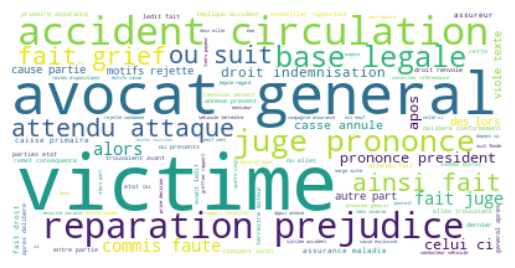

In [22]:
cloud_generator = WordCloud(background_color='white',
                            random_state=1)

wordcloud_image = WordCloud(background_color="white", max_words=20000)
wordcloud_image.generate(" ".join(mots))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.png")
plt.show()

On construit un second nuage de mots d'une forme différente cette fois et en utlisant la palette de couleurs définie au ci-dessus. de la même façon que sur le premier nuage de mots, on observe que les mots qui ressortent le plus sont notamment "accident circulation", "avocat général", "attendu", "attaque" et "réparation préjudice". En regardant les mots de plus près, nous pouvons apercevoir des mots plus spécifiques au thème des accidents de la route comme par exemple "véhicule terrestre", "compagnie assurance", "assurance maladie", "sécurité sociale", "circulation" et "véhicule impliqué".

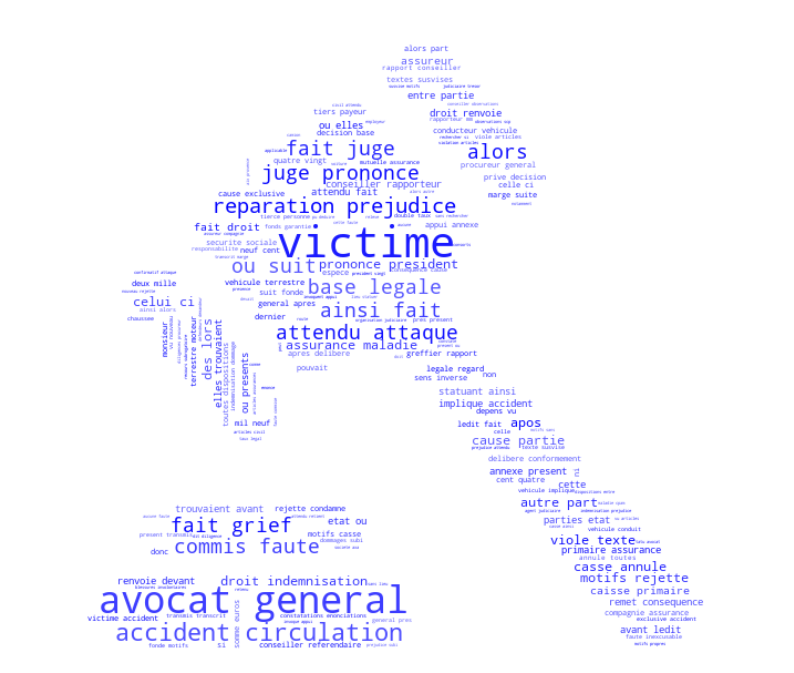

In [23]:
# chargement de l'image
mask = np.array(Image.open("img.png"))
image_colors = ImageColorGenerator(mask)

# création du nuage de mots
wc = WordCloud(background_color="white", max_words=50000, mask=mask)
wc.generate(" ".join(mots))

# affichage du nuage de mots
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wc.recolor(color_func=color_func), interpolation="bilinear")
ax.axis("off")
plt.savefig("wordcloud2.png")
plt.show()

Dans nos deux nuages de mots, on aperçoit que le mot "juillet" apparait très fréquement ce qui peut sembler étrange, nous allons donc tenter de comprendre pourquoi dans la suite de l'analyse.

## Graphique des dépendances 

In [24]:
spacy.cli.download('fr_dep_news_trf')
nlp = spacy.load('fr_dep_news_trf')
chaine = df_phrase["text"][9]
doc = nlp(chaine)
options = {"compact": True, "color": "blue", "bg": "#FFFFFF", 'distance' : 130}
print(displacy.render(doc, style='dep', jupyter=True, options=options))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.8/400.8 MB 1.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_dep_news_trf')


None


## Analyse des fréquences 

On analyse ensuite la fréquence d'apparition des mots dans le texte. Cette analyse nous permet d'avoir un aperçu clair des mots apparaissant le plus souvent dans nos données et par conséquent de visualiser les principaux thèmes de nos documents et remarquant les mots les plus importants du corpus.
Etudier la fréquance d'apparition des mots permet également de voir si certains mots apparraissent de façon récurrente dans nos documents mais ne sont pas pertinents à l'étude. Dans notre cas, on voit que "a" est le mot le plus fréquent, néanmoins, il n'apporte pas d'information sur les données, on décide donc de le retirer. Pour cela, on ajoute "a" au dictonnaire de stopwords.

Les initiales "x" et "z" appraissent de façon très récurrente également. Ces deux lettres servent à nommer les personnes d'une manière anonyme. On peut également les retirer de l'analyse.

Le terme "mme" a églement été retiré car il n'apporte pas vraiment d'indication sur les thèmes principaux. 

Ce graphique nous a donc été utile pour affiner notre dictionnaire de stopwords.

Une fois tous ces mots retirés, la fréquence d'apparition des mots est beaucoup plus propre. Les mots les plus fréquents sont "accident", "véhicule", "attendu" et "victime".

In [36]:
# Comptage de la fréquence d'apparition des mots
word_counts = nltk.FreqDist(mots)

# Afficher les 10 mots les plus fréquents
print(word_counts.most_common(10))
top_10 = word_counts.most_common(10)

# Afficher les 30 mots les plus fréquents 
print(word_counts.most_common(30))
top_30 = word_counts.most_common(30)

fig = px.bar(x = list(zip(*top_30))[0], y = list(zip(*top_30))[1], title = "Fréquence d'apparition des 30 mots les plus fréquents", labels = dict(x = "Mots", y = "Fréquence d'apparition"), color_discrete_sequence = ["#22DEEE"])
fig.show()
fig.write_image("freq.png")

# remarque : retirer les mots redondants pas utiles (a, cour, cassation, appel ?)

[('accident', 3732), ('attendu', 3605), ('vehicule', 3259), ('victime', 2667), ('fait', 2664), ('societe', 2514), ('prejudice', 2430), ('alors', 2293), ('faute', 2278), ('droit', 2111)]
[('accident', 3732), ('attendu', 3605), ('vehicule', 3259), ('victime', 2667), ('fait', 2664), ('societe', 2514), ('prejudice', 2430), ('alors', 2293), ('faute', 2278), ('droit', 2111), ('assureur', 2060), ('assurances', 1968), ('motifs', 1925), ('ainsi', 1914), ('indemnisation', 1885), ('ou', 1857), ('avocat', 1828), ('sans', 1637), ('cette', 1621), ('circulation', 1478), ('cause', 1467), ('conseiller', 1452), ('reparation', 1404), ('attaque', 1386), ('conducteur', 1367), ('viole', 1331), ('compagnie', 1254), ('etat', 1218), ('part', 1218), ('apres', 1216)]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Contexte d'apparition des mots 

On analyse ensuite le contexte d'apparition des mots. Cette analyse nous permet d'observer dans quels contexte certains mots sont utilisés. Il est intéressant d'avoir cette information notamment pour décerner les thèmes qui découlent du mot étudié. Il est également utile de regarder le contexte d'apparition des mots pour des mots ayant une fréquence importante et dont on cherche à determiner la cause de ce grand nombre d'apparition dans les documents.

Le mot délit est souvent suivi des mots "de blessures involontaires" ou "d'homicide involontaire". 

Nous voyons que le mot "juillet" apparait toujours entouré de 5 et 1985. En effet, ce jour la, une loi a été votée : Loi n° 85-677 du 5 juillet 1985 tendant à l'amélioration de la situation des victimes d'accidents de la circulation et à l'accélération des procédures d'indemnisation. Notre résultat est donc logique. Nous décidons tout de meme de supprimer ces mots de notre analyse pour la suite.

In [38]:
contexte_base = Text(phrase_base)
contexte = Text(phrase)

print("-----------------------------------")
print("Contexte d'apparition du mot crime")
print("-----------------------------------")
contexte.concordance("crime") 

print("-----------------------------------")
print("Contexte d'apparition du mot délit")
print("-----------------------------------")
contexte.concordance("délit") 

print("-----------------------------------")
print("Contexte d'apparition du mot victime")
print("-----------------------------------")
contexte.concordance("victime")

print("-----------------------------------")
print("Contexte d'apparition du mot juillet")
print("-----------------------------------")
contexte_base.concordance("juillet")

-----------------------------------
Contexte d'apparition du mot crime
-----------------------------------
Displaying 3 of 3 matches:
ivent , lors de la constatation ' un crime , ' un délit ou ' un accident de la 
ur présumé lorsqu ' il semble que le crime , le délit ou ' accident été commis 
n réparation du dommage causé par un crime , un délit ou une contravention appa
-----------------------------------
Contexte d'apparition du mot délit
-----------------------------------
Displaying 25 of 49 matches:
morale prévenue pour avoir commis le délit ' homicide involontaire sur la perso
estimant la demanderesse coupable du délit ' homicide involontaire pour avoir o
 de non - lieu partiel ' agissant du délit spécifique prévu par ' article . -- 
 pour des faits du juin du chef ' un délit qui ' est pas exclu du bénéfice de '
la loi du août , ' amnistie ' un tel délit ' est acquise qu ' après condamnatio
e celui - ci été déclaré coupable du délit de blessures involontaires ; Attendu
été pénale

Ici, l'analyse du contexte d'apparition des mots nous permet de répondre à notre interrogation sur l'apparition du mot "juillet" dans nos documents, et on remarque que ce mot apparaît lors de citations de la loi du 5 juillet 1985. D'après nos recherches, cette loi a pour but l'amélioration de la situation des victimes d'accidents de la circulation et l'accélération des procédures d'indemnisation.

## Matrice documents x termes 

On contruit la matrice document x termes, cette matrice donne le nombre d'apparition de chaque mot de la base de données dans chacun des textes du corpus. Cela permet ensuite d'analyser notamment la fréquence des mots (comme prédédemment) on encore de contruire un nuage de mots.

In [27]:
df = pd.read_csv("cleaned_text2.csv")
df = df["text"]
df

# Création de l'objet CountVectorizer
vectorizer = CountVectorizer(max_features=1000)

# Transformation des données en matrice de documents-termes
matrice_dt = vectorizer.fit_transform(df)

# Conversion de la matrice en DataFrame pandas pour affichage
df_matrice_dt = pd.DataFrame(matrice_dt.toarray(), columns=vectorizer.get_feature_names_out())
print(df_matrice_dt)

     absence  abstraction  accident  accidents  accueilli  accueillir  acte  \
0          0            0         9          2          0           0     0   
1          1            0        19          0          0           0     0   
2          1            0        14          0          0           0     1   
3          0            0         9          2          0           0     0   
4          1            0        11          0          0           0     0   
..       ...          ...       ...        ...        ...         ...   ...   
995        0            0         4          0          0           0     0   
996        0            0         1          0          0           0     0   
997        0            0         1          0          0           0     0   
998        0            0         2          0          0           0     0   
999        0            0         3          0          0           0     0   

     actes  action  activite  ...  voie  voies  voi

## AFC : Analyse factorielle des correspondances

On réalise ensuite une Analyse Factorielle des Correspondances (AFC). Cette analyse est une méthode d'analyse statistique qui permet de décrire la relation entre deux variables qualitatives. Elle permet de visualiser et d'analyser les relations entre les lignes et les colonnes d'un tableau croisé (dans notre cas : la matrice documents x termes). 

In [39]:
dc=pd.DataFrame(pd.get_dummies(df_matrice_dt))
dc.head()

# Instanciation de l'objet AFC
afc = prince.MCA(n_components=2)

# Entraînement de l'AFC sur les données
afc.fit(dc)

# Visualisation des résultats
afc.plot(dc)

alt.Chart(...)

En observant les résultats de notre AFC, on voit que certains mots semblent prochent les uns des autres mais cette visualisation n'étant que dans le plan, cela ne nous permet pas d'interpréter le graphique de façon fiable.

On voit toutefois que les mots "poids" et "lourd" sont très proches dans le graphique. Cela conforte nos résultats.

# Analyse thématique

## Importation des données

In [33]:
deci_jur = pd.read_csv("cleaned_text2.csv",  encoding = "utf-8")

# Suppresion des valeurs manquantes
deci_jur = deci_jur.dropna()
deci_jur = deci_jur.reset_index(drop=True)

In [34]:
# Création de la liste des tweets
list_deci_jur = []
for i in range(len(deci_jur)):
   list_deci_jur.append(str(deci_jur.iloc[i, 1]).split())

On peut maintenant réaliser une analyse thématique. Pour choisir le nombre de groupes, nous sommes parties avec 10 groupes. Les groupes se ressemblaient trop. Nous avons donc diminué le nombre de groupe jusqu'à arriver à 3 groupes. Les groupes sont assez caractéristiques.

In [35]:
# Pré-traitement des données
dictionary = corpora.Dictionary(list_deci_jur)

corpus = [dictionary.doc2bow(text) for text in list_deci_jur]

# Entraînement du modèle LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=100,
                     update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Afficher les thèmes générés par le modèle LDA
topics = lda_model.print_topics(num_words=8)
for topic in topics:
    print("Group : ", topic)

Group :  (0, '0.018*"vehicule" + 0.016*"accident" + 0.013*"attendu" + 0.008*"societe" + 0.008*"alors" + 0.007*"fait" + 0.007*"victime" + 0.007*"cause"')
Group :  (1, '0.013*"attendu" + 0.013*"avocat" + 0.012*"faute" + 0.010*"conseiller" + 0.008*"ou" + 0.008*"fait" + 0.008*"demeurant" + 0.008*"general"')
Group :  (2, '0.013*"victime" + 0.012*"prejudice" + 0.009*"attendu" + 0.008*"assureur" + 0.007*"accident" + 0.006*"indemnite" + 0.006*"assurances" + 0.006*"droit"')


Cette analyse de thèmes nous donne 3 groupes. Le premier groupe comprend les mots "véhicule", "accident", "fait", "societe", "cause". C'est donc un groupe de mots qui décrit le drame, l'accident qui s'est passé. 

Le second groupe de mot est un groupe qui à un coté plus juridique avec les mots "avocat", "général", "faute", "fait", "conseiller". 

Enfin, le dernier groupe est le thème de l'assurance. On le remarque grace aux mots "assureur", "indemnite", "assurance", "droit", "prejudice", "victime".

# Classificateur

## Importation des données 

On importe les données en coonservant uniquement les colonnes "text" et "solution". On remrque que la colonne "solution" prend 5 valeurs différentes mais que 3 d'entre elles sont présentes en très petit nombre. En effet, les valeurs other, annulation et irrecevabilité sont présents respectivement seulement 11, 4 et 3 fois. On choisit donc de les retirer de la base de données pour cette partie de l'analyse afin de ne pas fausser nos résultats.

In [45]:
df = pd.read_csv("data_nlp.csv")
df = df[["text", "solution"]]
print(df["solution"].value_counts())
df = df.drop(index=df[(df['solution'] == 'other') | (df['solution'] == 'annulation') | (df['solution'] == 'irrecevabilite')].index)
print(df["solution"].value_counts())

rejet             511
cassation         471
other              11
annulation          4
irrecevabilite      3
Name: solution, dtype: int64
rejet        511
cassation    471
Name: solution, dtype: int64


In [52]:
fig = px.histogram(df, x='solution', title = "Nombre de textes associés à chaque solution")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
text = df["text"]
solution = df["solution"]

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(text)

KeyError: 'solution'

La base de données contient 471 valeurs en cassation et 551 rejets.

## Séparation des données en échantillons train et test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, solution, test_size=0.2, random_state=42)
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

NameError: name 'X' is not defined

## Modélisation

### Classification Naive de Bayes

On contruit un modèle de classifcation naive de Bayes afin d'associer chaque texte à une solution. Pour cela, on contruit le modèle, on l'entraine sur nos données d'entraînement, puis on prédit sur l'ensemble de test et on évalue les performances du modèle en calculant l'accuracy, le rapport de classification (classifcation report) et la matice de confusion.

In [49]:
# Construction du modèle
clf = MultinomialNB()

# Entrainement du modèle
clf.fit(X_train, y_train)

# Prédictions sur l'ensemble test
y_pred = clf.predict(X_test)

# Evaluation des performances du modèle 
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print('Classification report:', report)
matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:', matrix)

NameError: name 'X_train' is not defined

Le modèle que nous avons contruit donnes 89.5% de bonnes prédictions. Cela signifie qu'il prédit la bonne "solution" pour 89.5% de nos textes de décisions de justices.

### Modèle SVM (Support Vector Machine)

Afin d'améliorer nos prédictions, on contruit un second modèle de classifcation. cette fois ci, on choisit de contruire un modèle SVM afin de prédire les solutions pour nos textes de justice. Comme pour le modèle de classification naive de Bayed, on construit le modèle, on l'entraîne sur les données d'entraînement, puis on prédit sur l'ensemble de teste et on évalue les performances du modèle.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Préparation des données
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text) # transformer les données textuelles en vecteurs numériques
y = solution

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle SVM
model = SVC(kernel='linear')

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Prédire les étiquettes de classe pour les données de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
report = classification_report(y_test, y_pred)
print('Classification report:', report)
matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:', matrix)

Accuracy: 0.9746192893401016
Classification report:               precision    recall  f1-score   support

   cassation       0.97      0.98      0.97        95
       rejet       0.98      0.97      0.98       102

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197

Confusion matrix: [[93  2]
 [ 3 99]]


On remarque que le modèle SVM est bien meilleur que le précédent puisqu'il prédit la bonne solution à 97.5% (contre 85.5% pour le modele de Bayes). 

In [ ]:
df = pd.DataFrame({"solutions" : y_pred})
fig = px.histogram(df, x='solutions', title = "Nombre de textes associés à chaque solution")
fig.show()